# COVID-19 Chest X-ray Classification

In this notebook, we will use COVID-19 Chest X-ray images from COVID-19 RADIOGRAPHY DATABASE https://www.kaggle.com/tawsifurrahman/covid19-radiography-database. In the following, we will do a multiclass classification to classify whether an X-ray image is normal, lung opacity,pneumonia or COVID-19. For this notebook we will use TPU for more efficient model training.


# 1. Import Libraries and Set-up
Let's import all the libraries we need first

In [1]:
#For loading and manipulating the data
import os
import random
from kaggle_datasets import KaggleDatasets

#For dealing with numbers and plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

#Deep learning libraries
import tensorflow as tf
from tensorflow.keras import mixed_precision
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense , Dropout, Activation
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation, RandomZoom, RandomHeight, RandomWidth, RandomContrast
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, LearningRateScheduler



Now we will configure TPU in this Kaggle Kernel for our model training later

In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except:
    strategy = strategy = tf.distribute.MirroredStrategy() 
print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


In [3]:
# We can try using mixed precision or XLA accelerate to boost our training
MIXED_PRECISION = True
XLA_ACCELERATE = True

if MIXED_PRECISION:
    try: 
        if tpu: policy = tf.keras.mixed_precision.Policy('mixed_bfloat16')
    except: 
        policy = tf.keras.mixed_precision.Policy('mixed_float16')
        mixed_precision.set_global_policy(policy)
    print('Mixed precision enabled')

if XLA_ACCELERATE:
    tf.config.optimizer.set_jit(True)
    print('Accelerated Linear Algebra enabled')

Mixed precision enabled
Accelerated Linear Algebra enabled


In [4]:
#Let's set some parameters first for later use
AUTOTUNE = tf.data.AUTOTUNE

# Configuration
IMG_SIZE = (224, 224)
SEED = 102
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
GCS_PATH = KaggleDatasets().get_gcs_path("covid19-radiography-database")


#Locate the file path of the images
file_path = "../input/covid19-radiography-database/COVID-19_Radiography_Dataset"

# 2. Get the files and Create dataset

In [5]:
#Get the GCS path of the file
filenames = tf.io.gfile.glob(GCS_PATH + '/COVID-19_Radiography_Dataset/*/*.png')
train_filenames, test_filenames = train_test_split(filenames, test_size=0.2, random_state=SEED)

In [6]:
# Get a list of unique class names in the image dataset
class_names = [item for item in os.listdir(file_path) 
           if os.path.isdir(os.path.join(file_path, item)) ]
print(f'Classes: {class_names}')

#print out the numbers of images
for class_name in class_names:
    train_num_class = len([filename for filename in train_filenames if class_name in filename.split('/')[-2]])
    test_num_class = len([filename for filename in test_filenames if class_name in filename.split('/')[-2]])
    print(f"{class_name} : {train_num_class} images in training set, {test_num_class} images in testing set")

Classes: ['Normal', 'Lung_Opacity', 'Viral Pneumonia', 'COVID']
Normal : 8156 images in training set, 2036 images in testing set
Lung_Opacity : 4792 images in training set, 1220 images in testing set
Viral Pneumonia : 1064 images in training set, 281 images in testing set
COVID : 2920 images in training set, 696 images in testing set


We will create a function to a tf.dataset in the next step.

In [7]:
def make_dataset(filenames, buffer_size=1024,batch_size=BATCH_SIZE, num_parallel_calls=AUTOTUNE, augment=False, config=True):    

    def get_label(file_path, class_names=class_names):
        parts = tf.strings.split(file_path, os.path.sep)
        one_hot = parts[-2] == class_names
        return tf.cast(one_hot, tf.int32)

    def decode_img(img):
        img = tf.image.decode_png(img, channels=3)
        img = tf.cast(img, tf.float32) / 255.0
        img = tf.image.resize(img, IMG_SIZE)
        return img

    def process_path(file_path):
        label = get_label(file_path)
        img = tf.io.read_file(file_path)
        img = decode_img(img)
        return img, label

    def configure_for_performance(ds,augment=False):
        ds = ds.shuffle(buffer_size=1024)
        ds = ds.batch(BATCH_SIZE)
        
        #If we want to do data augmentation to our images dataset
        if augment:
            ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

        ds = ds.repeat()
        ds = ds.prefetch(buffer_size=AUTOTUNE)
        return ds
    
    
    list_ds = tf.data.Dataset.from_tensor_slices(filenames)
    ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
    
    # here we set a config flag to prepare a test set without configuration for later analysis
    if config:
        ds = configure_for_performance(ds)
    else:
        ds = ds.batch(BATCH_SIZE)
    
    return ds

Here I used a few data augmentation parameters. Since the X-ray images tend to be in the regular in terms of the position and orientation, I don't choose to use great extent of data augmentation.

In [8]:
data_augmentation = Sequential([
    RandomWidth(0.1),
    RandomHeight(0.1),
    RandomRotation(0.01),
    RandomZoom(0.05),
    RandomContrast(0.1)
    
],name="data_augmentation")

In [9]:
#make training and test datasets
train_ds = make_dataset(train_filenames, augment=True)
test_ds = make_dataset(test_filenames)

In [10]:
#Let's count how many images there are in our training and testing datasets
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(tf.data.Dataset.from_tensor_slices(train_filenames)).numpy()
print("Training images: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(tf.data.Dataset.from_tensor_slices(test_filenames)).numpy()
print("Testing images: " + str(VAL_IMG_COUNT))

Training images: 16932
Testing images: 4233


Let's have a look of a batch in our training dataset and check whether the image and the labels are in correct shape

In [11]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label shape: ", label.numpy().shape)

Image shape:  (16, 224, 224, 3)
Label shape:  (16, 4)


We'll have to check whether our dataset is in correct shape.

In [12]:
train_ds,test_ds

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 4)), types: (tf.float32, tf.int32)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None, 4)), types: (tf.float32, tf.int32)>)

# 3. Visualize the images in the training dataset

Let's create a batch and visualize the images in the batch

In [13]:
image_batch, label_batch = next(iter(train_ds))

In [14]:
def show_batch(image_batch, label_batch, class_names=class_names, data_aug=False):
    image_batch = image_batch.numpy()
    label_batch = label_batch.numpy()
    plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(4,4,n+1)
        image = image_batch[n]
        plt.imshow(image)
        plt.title(class_names[np.argmax(label_batch[n])])
        plt.axis("off")

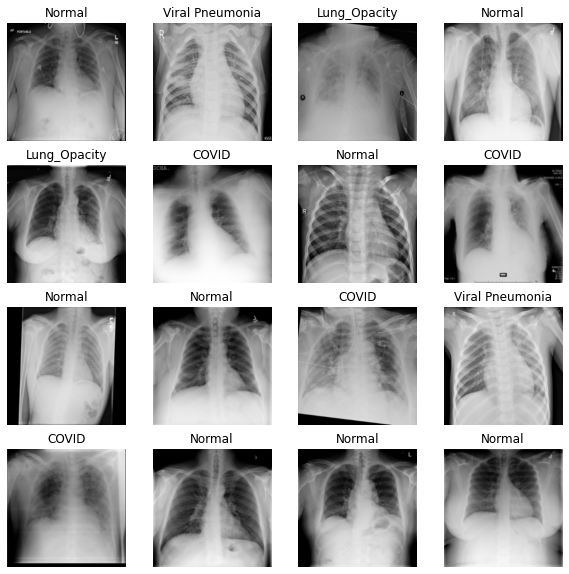

In [15]:
show_batch(image_batch, label_batch)

# 4. Model training

* Now we will set up some callbacks parameters right now

In [16]:
#Model Checkpoint for saving the best model during training
model_checkpoint = ModelCheckpoint('model.h5',
                                    montior='val_loss', 
                                    save_best_only=True, 
                                    verbose=0) 


# Reduce the learning rate on Plateau to minimun 1e-7
reduce_lr = ReduceLROnPlateau(monitor='val_loss',  
                            factor=0.2, 
                             patience=2,
                             verbose=1,
                             min_lr=1e-7)

#Early stopping when training hasn't improved for 2 epochs
early_stopping = EarlyStopping(
    patience=2,
    min_delta=0.001,
    restore_best_weights=True,
)

In [17]:
with strategy.scope():
    
    model = Sequential([
        Conv2D(filters=16, kernel_size= (2,2), activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid"),
        Conv2D(32, (3,3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid"),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid"),
        Flatten(),
        Dense(32),
        Dropout(0.2, input_shape=(32,)),
        Dense(4),
        Activation("softmax", dtype=tf.float32, name="softmax_float32")
    ])
    

    
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    
    model.compile(
        optimizer= tf.keras.optimizers.Adam(1e-4),
        loss="categorical_crossentropy",
        metrics=METRICS
    )
    
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 223, 223, 16)      208       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 43264)             0

In [18]:
# Comment out below lines to train the model
# history = model.fit(
#     train_ds,
#     epochs=25,
#     steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
#     validation_data=test_ds,
#     validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
#     callbacks= [reduce_lr, early_stopping,model_checkpoint]

# )


# Save the training history and output as csv
# hist_df = pd.DataFrame(history.history)
# hist_csv_file = 'history.csv'
# with open(hist_csv_file, mode='w') as f:
#     hist_df.to_csv(f)

# 5. Validation and Visualization

To save the time to retrain the model once restarts, we will load the saved trained model and do subsequent analysis.


In [19]:
# Load saved model
model = tf.keras.models.load_model('../input/covid19-xray-training-output/model.h5')

In [20]:
#Load training history
history = pd.read_csv('../input/covid19-xray-training-output/history.csv', index_col=0)
history

,loss,accuracy,precision,recall,val_loss,val_accuracy,val_precision,val_recall,lr
0,0.881707,0.635831,0.737494,0.479048,0.745012,0.690814,0.735162,0.621686,0.000100
1,0.648391,0.743573,0.788319,0.671507,0.602743,0.762784,0.798072,0.705492,0.000100
2,0.576666,0.779814,0.816363,0.726196,0.549342,0.791430,0.823837,0.746212,0.000100
3,0.544132,0.793918,0.825717,0.750536,0.527431,0.799479,0.830237,0.761837,0.000100
4,0.514155,0.809629,0.838419,0.768567,0.526956,0.795691,0.820487,0.758523,0.000100
5,0.489745,0.820043,0.847351,0.784218,0.491562,0.814157,0.839394,0.786932,0.000100
6,0.474421,0.825339,0.849462,0.794513,0.483233,0.815578,0.840587,0.786458,0.000100
7,0.449845,0.835039,0.858946,0.805939,0.483171,0.822917,0.843270,0.793561,0.000100
8,0.434872,0.844382,0.865526,0.815461,0.474871,0.822680,0.844234,0.800663,0.000100
9,0.425652,0.847477,0.865610,0.822185,0.454955,0.831676,0.851797,0.813684,0.000100


In [21]:
# Make a new test dataset without configuration for validation
test_ds = make_dataset(test_filenames,config=False)

#get all y true labels from the dataset
y_true = [class_names.index(name.split('/')[-2]) for name in test_filenames]

#using our model to predict and get y_predict
y_prob = model.predict(test_ds, verbose=1) 
y_predict = y_prob.argmax(axis=-1)

265/265 [==============================] - 584s 2s/step


In [22]:
#Let's see the classification report
print(classification_report(y_true, y_predict,target_names=class_names))

                 precision    recall  f1-score   support

         Normal       0.86      0.91      0.88      2036
   Lung_Opacity       0.84      0.79      0.82      1220
Viral Pneumonia       0.93      0.87      0.90       281
          COVID       0.86      0.82      0.84       696

       accuracy                           0.86      4233
      macro avg       0.87      0.85      0.86      4233
   weighted avg       0.86      0.86      0.86      4233



<AxesSubplot:>

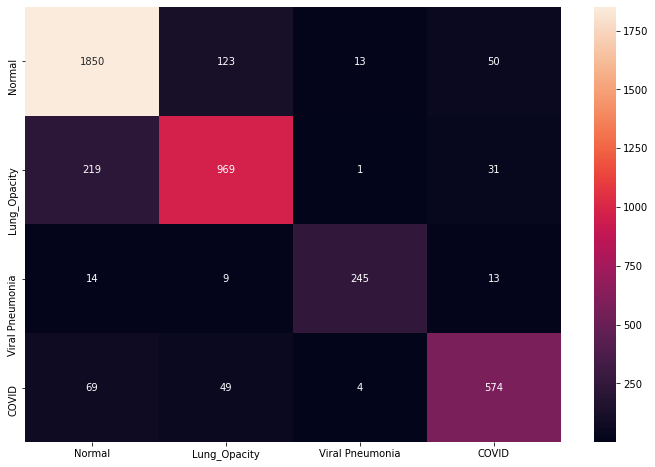

In [31]:
# Visualize confusion matrix
plt.figure(figsize=(12,8))
cm = confusion_matrix(y_true, y_predict)
sns.heatmap(cm, annot=True, fmt='d',xticklabels=class_names, yticklabels=class_names,)

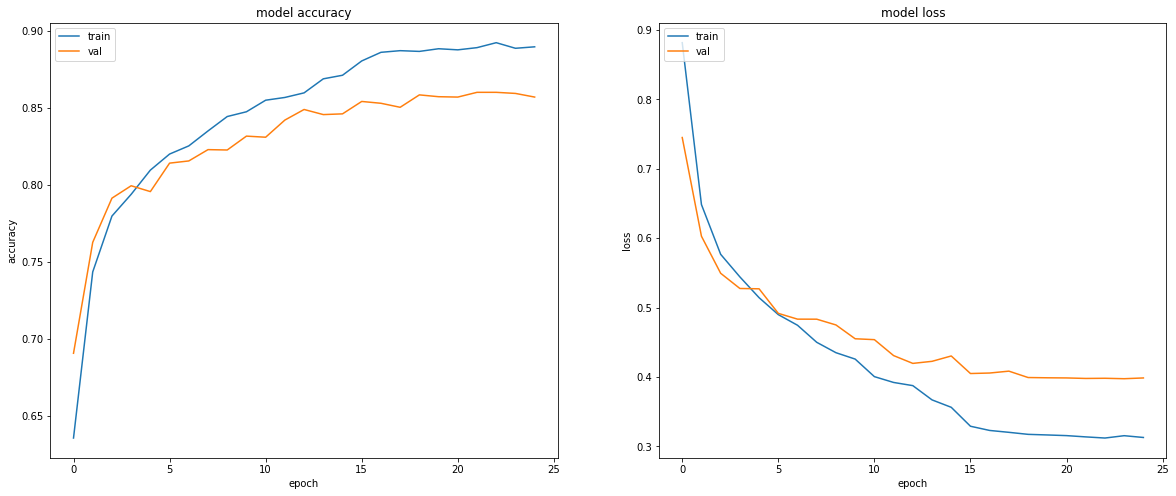

In [27]:
#plot learning history
plt.figure(figsize=(20,8))
plt.subplot(121)
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(122)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
